[INFO] Loaded FireProtDB: 31223 valid entries
[INFO] Collecting averaged embeddings + covariates...


Collecting: 100%|██████████████████████████████| 86/86 [00:00<00:00, 105.98it/s]


[INFO] Collected 21857 samples of dimension 36


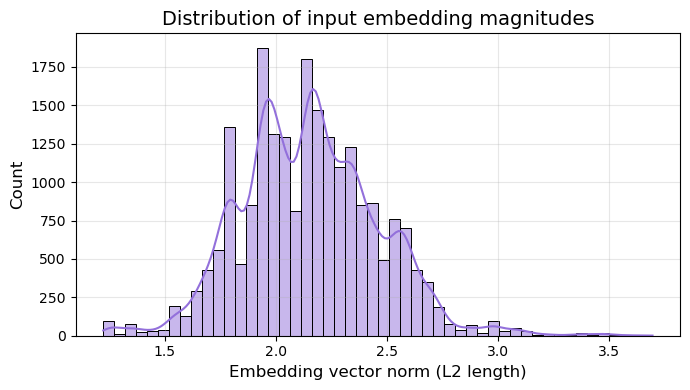

[STATS] mean=2.151, std=0.309, min=1.222, max=3.696
[INFO] Running UMAP dimensionality reduction...


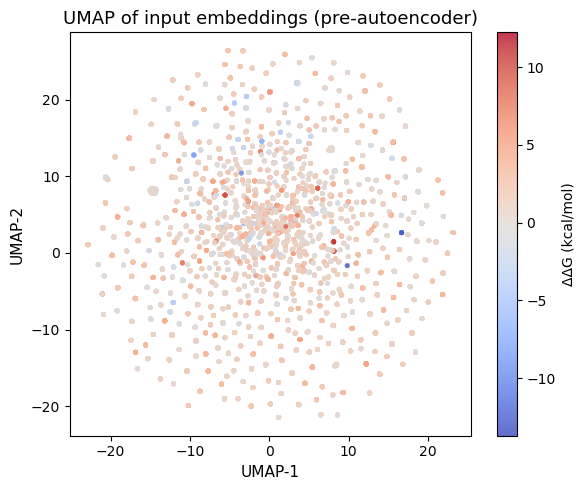

In [3]:
# =========================================================
# 🔍 FULL PIPELINE: Inspect pre-autoencoder input embeddings
# =========================================================
import os, math, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import umap

# =========================================================
# 1️⃣  Dataset utilities
# =========================================================
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AMINO_ACIDS)}
VOCAB_SIZE = len(AA_TO_IDX) + 1  # +1 for padding index 0

def tokenize_seq(seq, max_len=256):
    toks = [AA_TO_IDX.get(aa, 0) for aa in seq]
    toks = toks[:max_len] + [0] * max(0, max_len - len(toks))
    return torch.tensor(toks, dtype=torch.long)

def crop_around_mut(seq, pos, max_len):
    if len(seq) <= max_len:
        return seq
    half = max_len // 2
    start = max(0, pos - half)
    end = min(len(seq), start + max_len)
    return seq[start:end]

class FireProtDataset(Dataset):
    def __init__(self, csv_path, max_len=11):
        df = pd.read_csv(csv_path, low_memory=False)
        df = df[
            df["ddG"].notna() &
            df["sequence"].notna() &
            df["wild_type"].notna() &
            df["mutation"].notna() &
            df["position"].notna() &
            df["pH"].notna() &
            df["asa"].notna() &
            df["b_factor"].notna() &
            df["conservation"].notna()
        ].reset_index(drop=True)

        self.max_len = max_len
        covar_cols = ["pH", "asa", "b_factor", "conservation"]
        self.scaler = MinMaxScaler()
        df[covar_cols] = self.scaler.fit_transform(df[covar_cols])
        self.df = df
        print(f"[INFO] Loaded FireProtDB: {len(df)} valid entries")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wt_seq = list(row["sequence"])
        pos = int(row["position"]) - 1
        mut_seq = wt_seq.copy()
        if pos < len(mut_seq):
            mut_seq[pos] = row["mutation"]
        wt_seq = "".join(wt_seq)
        mut_seq = "".join(mut_seq)

        wt_seq = crop_around_mut(wt_seq, pos, self.max_len)
        mut_seq = crop_around_mut(mut_seq, pos, self.max_len)
        wt_tokens = tokenize_seq(wt_seq, self.max_len)
        mut_tokens = tokenize_seq(mut_seq, self.max_len)
        concat_seq = torch.cat([wt_tokens, mut_tokens], dim=0)

        covars = torch.tensor([
            float(row["pH"]),
            float(row["asa"]),
            float(row["b_factor"]),
            float(row["conservation"]),
        ], dtype=torch.float32)
        ddg_val = torch.tensor(float(row["ddG"]), dtype=torch.float32)
        return concat_seq, covars, ddg_val

# =========================================================
# 2️⃣  Conditional Autoencoder (embedding part only)
# =========================================================
class ConditionalAE(torch.nn.Module):
    def __init__(self, vocab_size, covar_dim=4, emb_dim=32,
                 hidden_dim=256, latent_dim=3, max_len=11):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim, padding_idx=0)
    def forward(self, seq):
        return self.embedding(seq).mean(dim=1)

# =========================================================
# 3️⃣  Load dataset & build DataLoader
# =========================================================
CSV_PATH = "fireprotdb_results.csv"   # path to your CSV
dataset = FireProtDataset(CSV_PATH, max_len=11)
train_ds, _, _ = random_split(dataset, [0.7, 0.15, 0.15],
                              generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=256, shuffle=False)

# =========================================================
# 4️⃣  Instantiate model and collect embeddings
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = ConditionalAE(vocab_size=VOCAB_SIZE).to(device)
vae.eval()

X_all, ddg_all = [], []
print("[INFO] Collecting averaged embeddings + covariates...")

for seq, covars, ddg in tqdm(train_loader, desc="Collecting"):
    seq, covars = seq.to(device), covars.to(device)
    with torch.no_grad():
        emb = vae(seq)                        # (B, emb_dim)
        feats = torch.cat([emb, covars], dim=1)  # (B, emb_dim + covar_dim)
    X_all.append(feats.cpu().numpy())
    ddg_all.append(ddg.numpy())

X_all = np.concatenate(X_all, axis=0)
ddg_all = np.concatenate(ddg_all, axis=0)
print(f"[INFO] Collected {X_all.shape[0]} samples of dimension {X_all.shape[1]}")

# =========================================================
# 5️⃣  Plot embedding magnitude distribution
# =========================================================
norms = np.linalg.norm(X_all, axis=1)
plt.figure(figsize=(7,4))
sns.histplot(norms, bins=50, kde=True, color="mediumpurple")
plt.xlabel("Embedding vector norm (L2 length)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of input embedding magnitudes", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"[STATS] mean={norms.mean():.3f}, std={norms.std():.3f}, "
      f"min={norms.min():.3f}, max={norms.max():.3f}")

# =========================================================
# 6️⃣  UMAP visualization colored by ΔΔG
# =========================================================
print("[INFO] Running UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap = reducer.fit_transform(X_all)

plt.figure(figsize=(6,5))
sc = plt.scatter(
    X_umap[:,0], X_umap[:,1],
    c=ddg_all, cmap="coolwarm", s=6, alpha=0.8
)
plt.colorbar(sc, label="ΔΔG (kcal/mol)")
plt.title("UMAP of input embeddings (pre-autoencoder)", fontsize=13)
plt.xlabel("UMAP-1", fontsize=11)
plt.ylabel("UMAP-2", fontsize=11)
plt.tight_layout()
plt.show()


In [3]:

T = 2

# everything everywhere all at once with dual regression
# =========================================================
# Joint Conditional Autoencoder + Diffusion Training (no KL)
# =========================================================
import os, math, torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# === Residual Block (shared across both networks) ===
# =========================================================
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim), nn.ReLU()
        )
    def forward(self, x): 
        return x + self.fc(x)

# =========================================================
# === Conditional Autoencoder (no KL, expressive) ===
# =========================================================
class RegressionHead(nn.Module):
    def __init__(self, latent_dim, covar_dim, hidden_dim=512, depth=4, dropout=0.3):
        super().__init__()
        input_dim = latent_dim + covar_dim
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(), nn.Dropout(dropout)
        )
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(), nn.Dropout(dropout),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(depth - 1)
        ])
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.input_proj(x)
        for block in self.blocks:
            h = h + block(h)
        return self.out(h)

# =========================================================
# === Transformer-based Conditional Autoencoder (Linear Decode)
# =========================================================
class ConditionalAE(nn.Module):
    def __init__(self, vocab_size, covar_dim=4, emb_dim=32,
                 hidden_dim=256, latent_dim=3, max_len=11,
                 n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.max_len = 2 * max_len          # L = 22 for max_len=11
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        self.covar_dim = covar_dim

        # --- Token and position embeddings ---
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.max_len, emb_dim))

        # --- Transformer encoder (context over tokens) ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # --- Pooling + latent projection (sequence → z) ---
        self.enc_fc = nn.Sequential(
            nn.Linear(emb_dim + covar_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # --- STRICTLY LINEAR decoder (z,covars → flattened logits) ---
        # Output dimension = L * V (position-specific token logits)
        self.decoder_linear = nn.Linear(latent_dim + covar_dim,
                                        self.max_len * vocab_size, bias=True)

        # --- Regression head for ΔΔG (unchanged) ---
        self.reg_head = RegressionHead(
            latent_dim=latent_dim,
            covar_dim=covar_dim,
            hidden_dim=512,
            depth=4,
            dropout=0.3
        )

    # ----------------------------------------------------
    # Encode sequence → latent z
    # ----------------------------------------------------
    def encode(self, seq, covars):
        """
        seq:    (B, L)  integer tokens
        covars: (B, covar_dim)
        """
        x = self.embedding(seq) + self.pos_embedding[:, :seq.size(1), :]  # (B, L, E)
        x = self.transformer(x)                                           # (B, L, E)
        x_pooled = x.mean(dim=1)                                          # (B, E)
        h_cat = torch.cat([x_pooled, covars], dim=1)                      # (B, E+C)
        z = self.enc_fc(h_cat)                                            # (B, Z)
        return z

    # ----------------------------------------------------
    # Decode latent z → sequence logits + ddG prediction
    # ----------------------------------------------------
    def decode(self, z, covars):
        inp = torch.cat([z, covars], dim=1)                               # (B, Z+C)
        flat_logits = self.decoder_linear(inp)                             # (B, L*V)
        seq_logits = flat_logits.view(-1, self.max_len, self.vocab_size)   # (B, L, V)
        ddg_pred = self.reg_head(inp).squeeze(-1)                          # (B,)
        return seq_logits, ddg_pred

    # ----------------------------------------------------
    # Forward
    # ----------------------------------------------------
    def forward(self, seq, covars):
        z = self.encode(seq, covars)
        seq_logits, ddg_pred = self.decode(z, covars)
        return seq_logits, ddg_pred, z



# =========================================================
# === Diffusion Denoiser (expressive, as before) ===
# =========================================================
class FourierFeatures(nn.Module):
    def __init__(self, in_dim=1, num_freqs=8):
        super().__init__()
        freqs = 2 ** torch.arange(num_freqs).float() * math.pi
        self.register_buffer("freqs_buf", freqs)
    def forward(self, x):
        x_proj = x.unsqueeze(-1) * self.freqs_buf
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim, T=200, hidden_dim=128, depth=2, dropout=0.1):
        super().__init__()
        self.T = T
        self.embed_t = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)
        )
        self.embed_y = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)
        )
        input_dim = latent_dim + 2 * hidden_dim
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(depth):
            layers += [ResidualBlock(hidden_dim, dropout=dropout)]
        layers += [nn.Linear(hidden_dim, latent_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, zt, t, y):
        # --- Time embedding ---
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t_embed = self.embed_t(t / self.T)

        # --- ΔΔG embedding ---
        # y may be [B], [B, 1], or higher-dim — collapse safely to [B, 1]
        if y.dim() > 2:
            y = y.view(y.size(0), -1).mean(dim=1, keepdim=True)
        elif y.dim() == 1:
            y = y.unsqueeze(-1)
        y_embed = self.embed_y(y)

        # --- Combine and predict ---
        h = torch.cat([zt, t_embed, y_embed], dim=1)
        return self.net(h)


def train_joint_infery(
    model, denoiser, loaders, vocab_size,
    T=200, epochs=100, lr=5e-4,
    lambda_recon=1.0, lambda_diff=1.0,
    lambda_cond=1e-4, lambda_yinf=10.0,
    lambda_reg= .25,
    lambda_path=1e-3,
    inner_steps=5, inner_lr=0.1,
    n_path_steps=T,
    warmup_epochs=0,
    device=None,
    model_path="best_joint_infery.pt"
):
    import time
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, denoiser = model.to(device), denoiser.to(device)
    opt = torch.optim.AdamW(list(model.parameters()) + list(denoiser.parameters()), lr=lr)

    # === Diffusion schedule ===
    betas = torch.linspace(1e-4, 0.02, T).to(device)
    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    r_t = torch.ones_like(betas)

    # ------------------------------------------------------------
    # Path objective
    # ------------------------------------------------------------
    def trajectory_path_objective_per_sample(z0, y, denoiser, betas, r_t, T,
                                             n_steps=T, n_paths=1):
        B, D = z0.shape
        dt = 1.0 / n_steps
        totals = torch.zeros(B, device=z0.device, dtype=z0.dtype)
        for _ in range(n_paths):
            zt = z0.clone()
            total_p = torch.zeros_like(totals)
            for k in range(n_steps):
                t_norm = torch.full((B, 1), k / n_steps, device=z0.device, dtype=z0.dtype)
                beta_t = betas[min(int(k / n_steps * (T - 1)), T - 1)]
                drift_forward = -0.5 * beta_t * zt
                noise = torch.randn_like(zt)
                dz = drift_forward * dt + torch.sqrt(beta_t * dt) * noise
                zt = zt + dz
                s = denoiser(zt, t_norm * T, y)
                grad_U = zt
                drift_term = 0.5 * r_t[k % len(r_t)] * (
                    -s.pow(2).sum(dim=1) + (s * grad_U).sum(dim=1)
                )
                work_term = (s * dz).sum(dim=1)
                total_p += (drift_term + work_term)
            totals += total_p
        return (totals / n_paths).mean()

    # ------------------------------------------------------------
    # y-inference inner loop
    # ------------------------------------------------------------
    def infer_y_unrolled(z0, denoiser, betas, r_t, T,
                         inner_steps=5, inner_lr=0.01,
                         traj_steps=T, n_paths=1,clip_value = 10.,
                         clamp=(-15.0, 20.0)):
        B = z0.size(0)
        y = torch.zeros(B, 1, device=z0.device, requires_grad=True)
        for _ in range(inner_steps):
            Jb = trajectory_path_objective_per_sample(
                z0, y, denoiser, betas, r_t, T,
                n_steps=traj_steps, n_paths=n_paths
            )
            grad_y = torch.autograd.grad(Jb, y, create_graph=True, retain_graph=True)[0]
            grad_y = torch.nan_to_num(grad_y, nan=0.0, posinf=0.0, neginf=0.0)
            # grad_y = torch.clamp(grad_y, -clip_value, clip_value)
            y = (y + inner_lr * grad_y).clamp(*clamp)
            y.requires_grad_(True)
        return y




    # # === Stabilized gradient ascent on y (with optional trajectory) ===
    # def infer_y_stable(z0, ddg_true=None, record_traj=False):
    #     B = z0.size(0)
    #     y = torch.zeros(B, 1, device=device, requires_grad=True)
    #     traj = [y.detach().cpu().numpy().flatten()]
    #     for _ in range(inner_steps):
    #         with torch.enable_grad():
    #             Jb = trajectory_path_objective(z0, y)
    #             grad_y = torch.autograd.grad(Jb, y, retain_graph=False, create_graph=False)[0]
    #         grad_y = torch.nan_to_num(grad_y, nan=0.0, posinf=0.0, neginf=0.0)
    #         grad_y = torch.clamp(grad_y, -clip_value, clip_value)
    #         new_y = (y + inner_lr * grad_y).clamp(-15, 20)
    #         y = (1 - damping) * y + damping * new_y
    #         y.requires_grad_(True)
    #         if record_traj:
    #             traj.append(y.detach().cpu().numpy().flatten())

    #     if record_traj:
    #         traj = np.stack(traj, axis=0)
    #         if ddg_true is not None:
    #             plt.figure(figsize=(5, 3))
    #             plt.plot(traj[:, 0], lw=2, label="inferred y")
    #             plt.axhline(ddg_true.item(), color='r', ls='--', label='true ΔΔG')
    #             plt.title("Inner GD trajectory of y")
    #             plt.xlabel("Inner iteration"); plt.ylabel("y")
    #             plt.legend(); plt.tight_layout(); plt.show()
    #         return y, traj
    #     return y

    # ------------------------------------------------------------
    # Training loop
    # ------------------------------------------------------------
    print("[Info] Starting joint AE + diffusion training (dual regression metrics)...")
    best_r2, best_epoch = -np.inf, -1

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        model.train(); denoiser.train()
        totals = {"recon": 0, "diff": 0, "cond": 0, "yinf": 0, "reg": 0, "path": 0}
        total_loss = 0.0
        y_true, y_pred_yinf, y_pred_reg = [], [], []
        use_diff = epoch > warmup_epochs

        # === TRAIN ===
        for seq, covars, ddg in loaders["train"]:
            seq, covars, ddg = seq.to(device), covars.to(device), ddg.to(device)
            opt.zero_grad()

            # --- AE forward ---
            seq_logits, ddg_pred, z = model(seq, covars)
            loss_recon = F.cross_entropy(seq_logits.view(-1, vocab_size),
                                         seq.view(-1), ignore_index=0)
            loss_reg = F.mse_loss(ddg_pred.squeeze(), ddg)

            # --- Diffusion-inferred y ---
            y_hat = infer_y_unrolled(
                z, denoiser, betas, r_t, T,
                inner_steps=inner_steps, inner_lr=inner_lr,
                traj_steps=n_path_steps, n_paths=1
            )
            loss_yinf = F.mse_loss(y_hat.squeeze(), ddg)

            # --- Diffusion training ---
            if use_diff:
                t = torch.randint(0, T, (z.size(0),), device=device)
                noise = torch.randn_like(z)
                zt = torch.sqrt(alphas_bar[t]).unsqueeze(1) * z + torch.sqrt(1 - alphas_bar[t]).unsqueeze(1) * noise
                pred = denoiser(zt, t, ddg)
                loss_diff = F.mse_loss(pred, noise)
                loss_cond = 1.0 - F.cosine_similarity(
                    F.normalize(pred, dim=1),
                    F.normalize(z - zt, dim=1), dim=1
                ).mean()
                loss_path = -trajectory_path_objective_per_sample(
                    z, ddg.unsqueeze(1), denoiser, betas, r_t, T,
                    n_steps=n_path_steps, n_paths=1
                )
            else:
                loss_diff = loss_cond = loss_path = torch.tensor(0.0, device=device)

            # --- Total loss ---
            loss = (lambda_recon * loss_recon
                    + lambda_diff * loss_diff
                    + lambda_cond * loss_cond
                    + lambda_yinf * loss_yinf
                    + lambda_reg * loss_reg
                    + lambda_path * loss_path)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(denoiser.parameters()), 1.0)
            opt.step()

            # --- Logging stats ---
            bs = seq.size(0)
            total_loss += loss.item() * bs
            for k, v in [("recon", loss_recon), ("diff", loss_diff),
                         ("cond", loss_cond), ("yinf", loss_yinf),
                         ("reg", loss_reg), ("path", loss_path)]:
                totals[k] += v.item() * bs
            y_true.extend(ddg.cpu().numpy())
            y_pred_yinf.extend(y_hat.detach().cpu().numpy())
            y_pred_reg.extend(ddg_pred.detach().cpu().numpy())

        n_train = len(loaders["train"].dataset)
        for k in totals: totals[k] /= n_train
        total_loss /= n_train
        r2_train_yinf = r2_score(y_true, y_pred_yinf)
        r2_train_reg = r2_score(y_true, y_pred_reg)

        # === VALIDATION ===
        model.eval()
        yv_true, yv_pred_yinf, yv_pred_reg = [], [], []
        val_loss, val_recon, val_yinf, val_reg = 0.0, 0.0, 0.0, 0.0

        for seq, covars, ddg in loaders["val"]:
            seq, covars, ddg = seq.to(device), covars.to(device), ddg.to(device)
            with torch.no_grad():
                seq_logits, ddg_pred, z = model(seq, covars)
                l_recon = F.cross_entropy(seq_logits.view(-1, vocab_size),
                                          seq.view(-1), ignore_index=0)
                l_reg = F.mse_loss(ddg_pred.squeeze(), ddg)
            # y-inference requires gradients internally
            y_hat_val = infer_y_unrolled(
                z, denoiser, betas, r_t, T,
                inner_steps=inner_steps, inner_lr=inner_lr,
                traj_steps=n_path_steps, n_paths=1
            )
            l_yinf = F.mse_loss(y_hat_val.squeeze(), ddg)

            val_loss += (lambda_recon * l_recon + lambda_yinf * l_yinf + lambda_reg * l_reg).item() * seq.size(0)
            val_recon += l_recon.item() * seq.size(0)
            val_yinf += l_yinf.item() * seq.size(0)
            val_reg += l_reg.item() * seq.size(0)
            yv_true.extend(ddg.cpu().numpy())
            yv_pred_yinf.extend(y_hat_val.detach().cpu().numpy())
            yv_pred_reg.extend(ddg_pred.detach().cpu().numpy())

        n_val = len(loaders["val"].dataset)
        val_loss /= n_val
        val_recon /= n_val
        val_yinf /= n_val
        val_reg /= n_val
        r2_val_yinf = r2_score(yv_true, yv_pred_yinf)
        r2_val_reg = r2_score(yv_true, yv_pred_reg)

        # === Logging ===
        print(f"\nEpoch {epoch}/{epochs} | Time {time.time()-t0:.1f}s | Diffusion={'ON' if use_diff else 'OFF'}")
        print(f"  TRAIN | R²(y_inf)={r2_train_yinf:.3f} | R²(reg)={r2_train_reg:.3f} | "
              f"Total={total_loss:.4f} | Recon={totals['recon']:.4f} | Reg={totals['reg']:.4f} | "
              f"yInf={totals['yinf']:.4f} | Diff={totals['diff']:.4f} | Path={totals['path']:.4f}")
        print(f"  VAL   | R²(y_inf)={r2_val_yinf:.3f} | R²(reg)={r2_val_reg:.3f} | "
              f"Total={val_loss:.4f} | Recon={val_recon:.4f} | yInf={val_yinf:.4f} | Reg={val_reg:.4f}")

        if r2_val_yinf > best_r2:
            best_r2, best_epoch = r2_val_yinf, epoch
            torch.save({
                "model": model.state_dict(),
                "denoiser": denoiser.state_dict(),
                "epoch": epoch,
                "r2_val_reg": r2_val_reg,
                "r2_val_yinf": r2_val_yinf
            }, model_path)
            print(f"  → Saved best model @ epoch {epoch} "
                  f"(R²(reg)={r2_val_reg:.3f}, R²(y_inf)={r2_val_yinf:.3f})")

    print(f"\n[TRAINING DONE] Best validation R²(reg)={best_r2:.3f} (epoch {best_epoch})")
    return model, denoiser






# =========================================================
# 1️⃣ Imports
# =========================================================
import torch, math, os, numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm




# # --- quick gradient sanity test ---
# latent_dim = 3
# T = 2
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dummy_denoiser = ConditionalDenoiser(latent_dim=latent_dim, T=T, hidden_dim=64, depth=2).to(device)
# betas = torch.linspace(1e-4, 0.02, T).to(device)
# r_t = torch.ones_like(betas)

# z0 = torch.randn(4, latent_dim, device=device)
# y = torch.zeros(4, 1, device=device, requires_grad=True)

# Jb = trajectory_path_objective_per_sample(z0, y, dummy_denoiser, betas, r_t, T)
# print("Jb.requires_grad:", Jb.requires_grad)

# grad_y = torch.autograd.grad(Jb, y, create_graph=True)[0]
# print("grad_y shape:", grad_y.shape, "requires_grad:", grad_y.requires_grad)



# =========================================================
# 2️⃣ FireProt Dataset
# =========================================================
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_IDX = {aa: i+1 for i, aa in enumerate(AMINO_ACIDS)}
VOCAB_SIZE = len(AA_TO_IDX) + 1

def tokenize_seq(seq, max_len=256):
    toks = [AA_TO_IDX.get(aa, 0) for aa in seq]
    toks = toks[:max_len] + [0] * max(0, max_len - len(toks))
    return torch.tensor(toks, dtype=torch.long)

def crop_around_mut(seq, pos, max_len):
    if len(seq) <= max_len: return seq
    half = max_len // 2
    start = max(0, pos - half)
    end = min(len(seq), start + max_len)
    return seq[start:end]

# =========================================================
# FireProt Dataset (robust cleaning)
# =========================================================
class FireProtDataset(Dataset):
    def __init__(self, csv_path, max_len=256):
        # --- Load CSV safely ---
        df = pd.read_csv(csv_path, low_memory=False)
        
        # --- Count and print ddG stats before filtering ---
        total = len(df)
        nonna = df["ddG"].notna().sum()
        print(f"[INFO] FireProtDB loaded ({total:,} rows total)")
        print(f"[INFO] ΔΔG non-NaN measurements: {nonna:,} ({nonna/total:.2%})")

        # --- Filter rows with missing key fields ---
        df = df[
            df["ddG"].notna() &
            df["sequence"].notna() &
            df["wild_type"].notna() &
            df["mutation"].notna() &
            df["position"].notna() &
            df["pH"].notna() &
            df["asa"].notna() &
            df["b_factor"].notna() &
            df["conservation"].notna()
        ].reset_index(drop=True)

        self.max_len = max_len
        self.df = df

        # --- Normalize covariates ---
        covar_cols = ["pH", "asa", "b_factor", "conservation"]
        self.scaler = MinMaxScaler()
        self.df[covar_cols] = self.scaler.fit_transform(self.df[covar_cols])

        # --- Print clean summary ---
        print(f"[INFO] After filtering: {len(df):,} valid entries")
        print(f"[INFO] ΔΔG range: {df['ddG'].min():.2f} → {df['ddG'].max():.2f}")
        print(f"[INFO] ΔΔG mean ± std: {df['ddG'].mean():.2f} ± {df['ddG'].std():.2f}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wt_seq = list(row["sequence"])
        pos = int(row["position"]) - 1

        if pos < len(wt_seq) and wt_seq[pos] == row["wild_type"]:
            mut_seq = wt_seq.copy()
            mut_seq[pos] = row["mutation"]
            wt_seq = "".join(wt_seq)
            mut_seq = "".join(mut_seq)
        else:
            wt_seq = row["sequence"]
            mut_seq = row["sequence"]

        wt_seq = crop_around_mut(wt_seq, pos, self.max_len)
        mut_seq = crop_around_mut(mut_seq, pos, self.max_len)
        wt_tokens = tokenize_seq(wt_seq, self.max_len)
        mut_tokens = tokenize_seq(mut_seq, self.max_len)
        concat_seq = torch.cat([wt_tokens, mut_tokens], dim=0)

        covars = torch.tensor([
            float(row["pH"]),
            float(row["asa"]),
            float(row["b_factor"]),
            float(row["conservation"]),
        ], dtype=torch.float32)

        ddg_val = torch.tensor(float(row["ddG"]), dtype=torch.float32)
        return concat_seq, covars, ddg_val



# =========================================================
# 3️⃣ Build loaders
# =========================================================
CSV_PATH = "fireprotdb_results.csv"
dataset = FireProtDataset(CSV_PATH, max_len=11)
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
                                         generator=torch.Generator().manual_seed(42))

loaders = {
    "train": DataLoader(train_ds, batch_size=256, shuffle=True),
    "val":   DataLoader(val_ds, batch_size=256),
    "test":  DataLoader(test_ds, batch_size=256),
}

# =========================================================
# 4️⃣ Initialize models
# =========================================================


# T = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim=3


# vae = ConditionalAE(
#     vocab_size=VOCAB_SIZE,
#     covar_dim=4,
#     emb_dim=32,
#     hidden_dim=256,
#     latent_dim=latent_dim,
#     max_len=11,
#     n_heads=4,
#     n_layers=2,
#     dropout=0.1
# ).to(device)


# denoiser = ConditionalDenoiser(
#     latent_dim=latent_dim,
#     T=T,
#     hidden_dim=128,
#     depth=4
# ).to(device)





# # =========================================================
# # === Train AE + Diffusion with implicit ΔΔG inference ===
# # =========================================================
# vae, denoiser = train_joint_infery(
#     model=vae,
#     denoiser=denoiser,
#     loaders=loaders,
#     vocab_size=VOCAB_SIZE,
#     T=T,                 # you can raise to 50–200 later
#     epochs= 2500,          # 300–500 is usually enough
#     lr=1.*1e-4,
#     lambda_recon=1.0,
#     lambda_diff= 0.,
#     lambda_cond=0.,
#     lambda_yinf=10.0,    # outer MSE between inferred y_hat and true ΔΔG
#     lambda_path=0.,    # global path-likelihood regularizer
#     inner_steps=10,       # gradient ascent iterations on y
#     inner_lr=.1,        # inner learning rate
#     n_path_steps=T,      # discretization of path integral
#     warmup_epochs=0,
#     device=device,
#     model_path="best_joint_linear_decoder_transformer_embeddings_T"+str(T)+"_Final.pt"
# )




[INFO] FireProtDB loaded (53,445 rows total)
[INFO] ΔΔG non-NaN measurements: 39,177 (73.30%)
[INFO] After filtering: 31,223 valid entries
[INFO] ΔΔG range: -13.70 → 17.40
[INFO] ΔΔG mean ± std: 1.03 ± 1.75


In [4]:
# =========================================================
# Load Trained ConditionalAE + Denoiser Models
# =========================================================
import torch

# --- Config ---
T = 2
latent_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "best_joint_linear_decoder_transformer_embeddings_T2_Final.pt"

# --- Reinitialize architectures (must match training setup) ---
vae = ConditionalAE(
    vocab_size=VOCAB_SIZE,
    covar_dim=4,
    emb_dim=32,
    hidden_dim=256,
    latent_dim=latent_dim,
    max_len=11,
    n_heads=4,
    n_layers=2,
    dropout=0.1
).to(device)

denoiser = ConditionalDenoiser(
    latent_dim=latent_dim,
    T=T,
    hidden_dim=128,
    depth=4
).to(device)

# --- Load weights ---
ckpt = torch.load(ckpt_path, map_location=device)
vae.load_state_dict(ckpt["model"])
denoiser.load_state_dict(ckpt["denoiser"])

vae.eval()
denoiser.eval()

print(f"[INFO] Loaded trained models from {ckpt_path}")
print(f"→ Epoch {ckpt.get('epoch', 'N/A')}, "
      f"R²(reg)={ckpt.get('r2_val_reg', 'N/A')}, "
      f"R²(y_inf)={ckpt.get('r2_val_yinf', 'N/A')}")


[INFO] Loaded trained models from best_joint_linear_decoder_transformer_embeddings_T2_Final.pt
→ Epoch 281, R²(reg)=0.7068393142867567, R²(y_inf)=0.7679830068967705


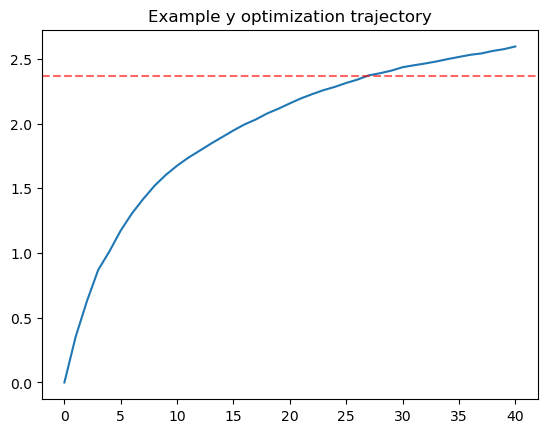

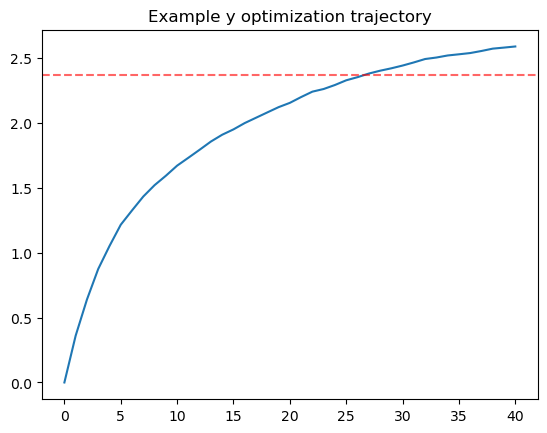

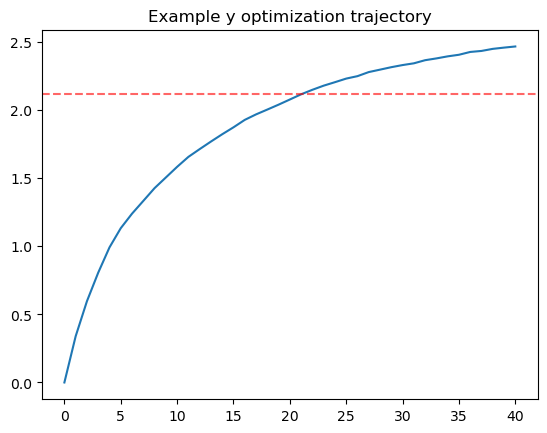

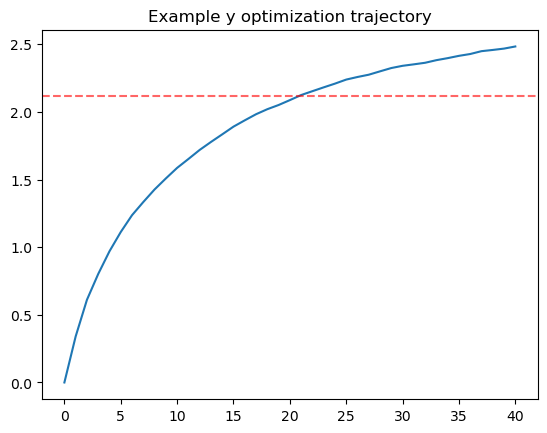

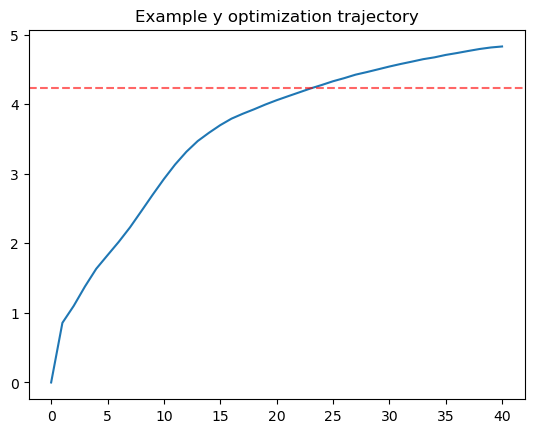

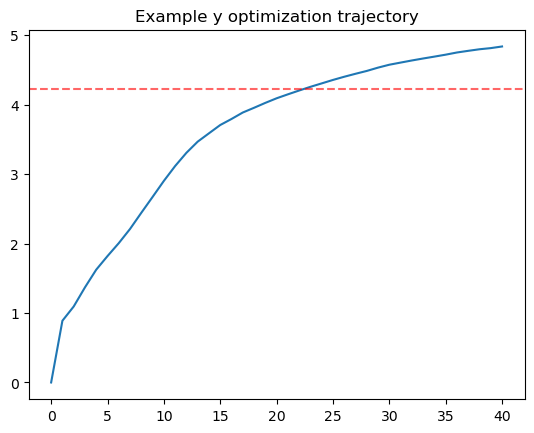

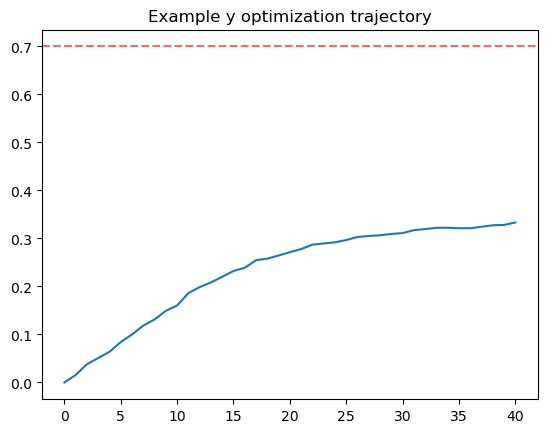

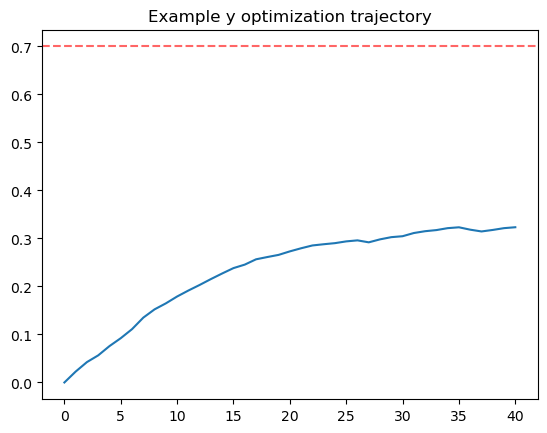

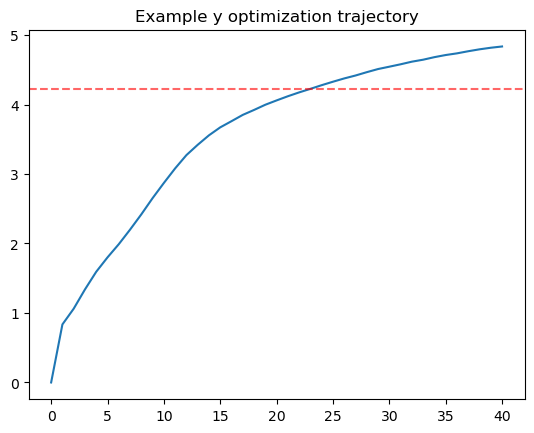

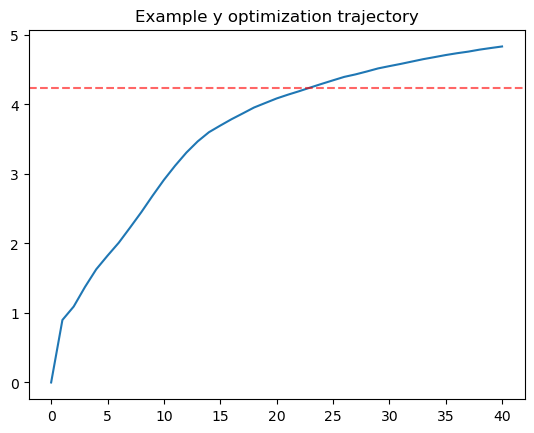

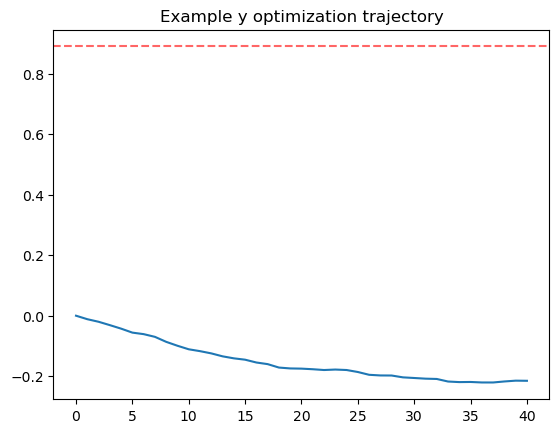

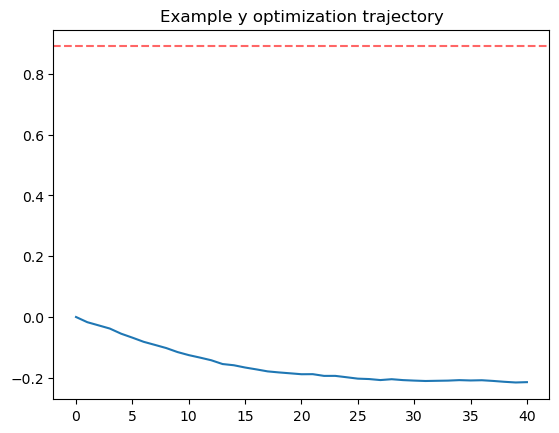

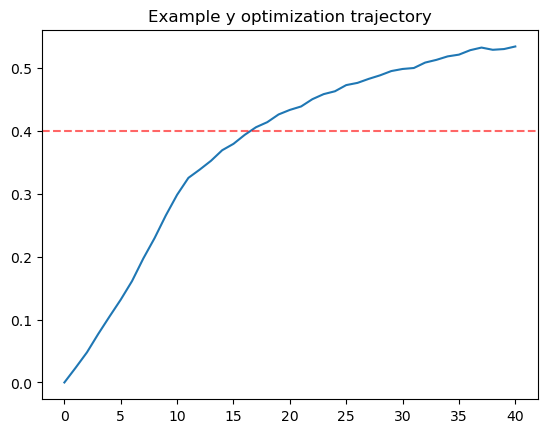

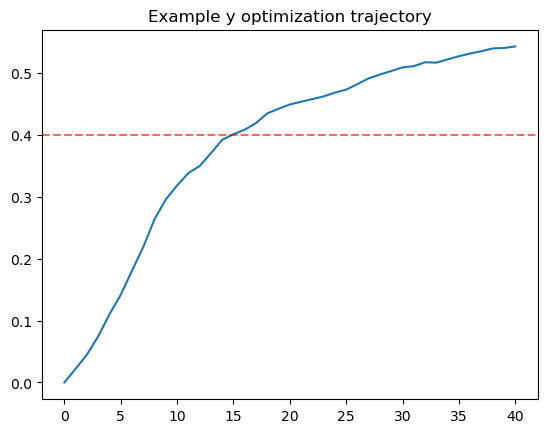

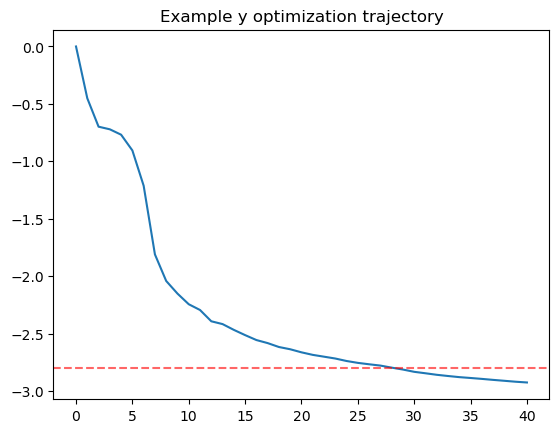

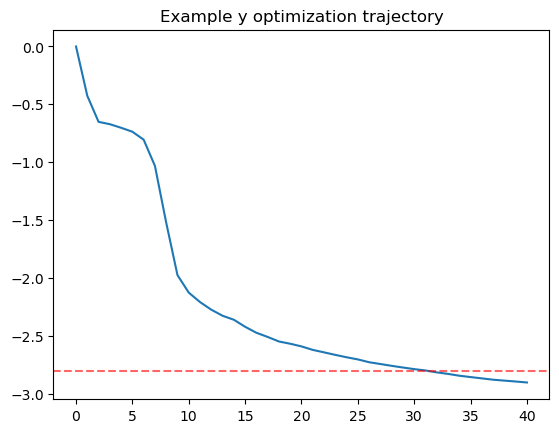

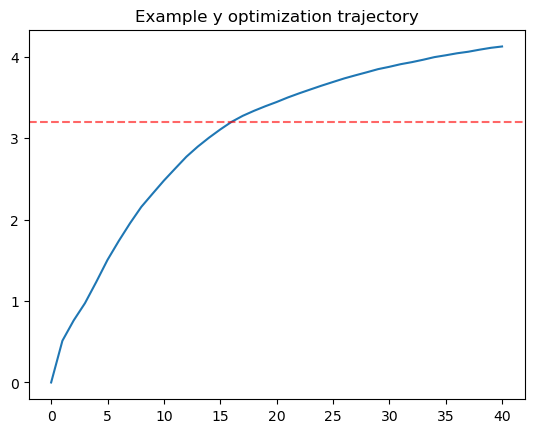

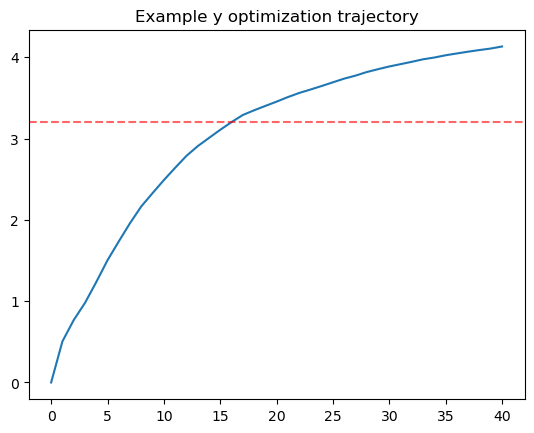

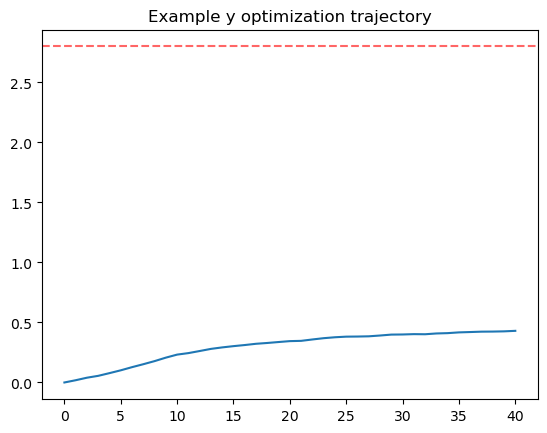

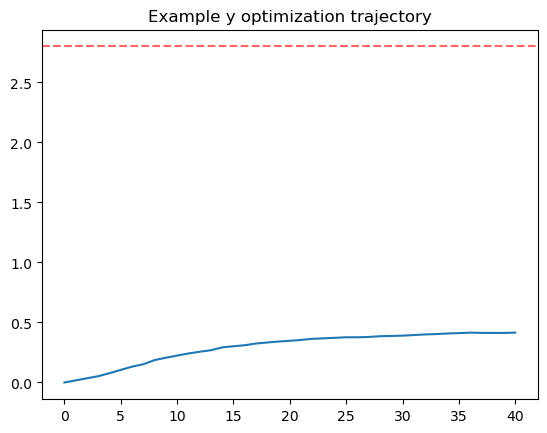

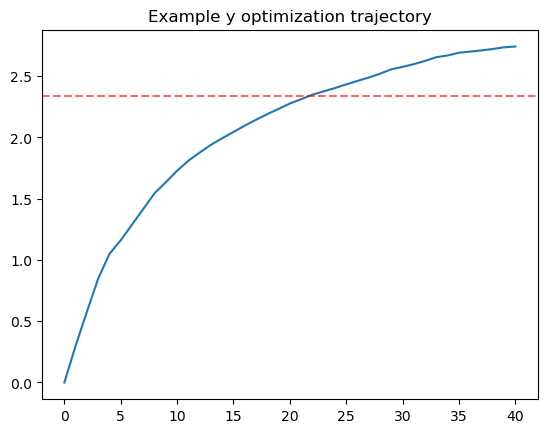

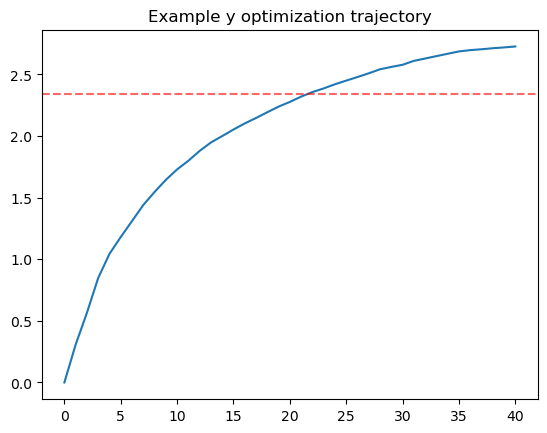

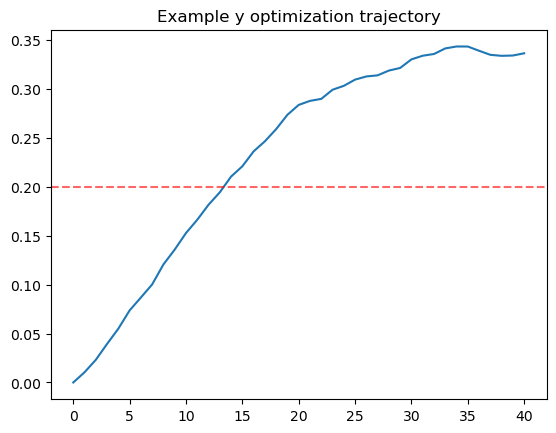

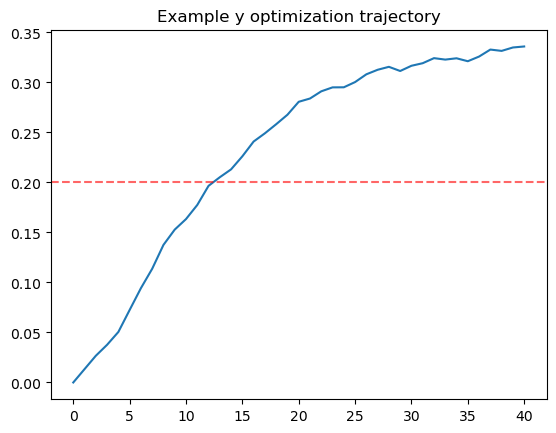

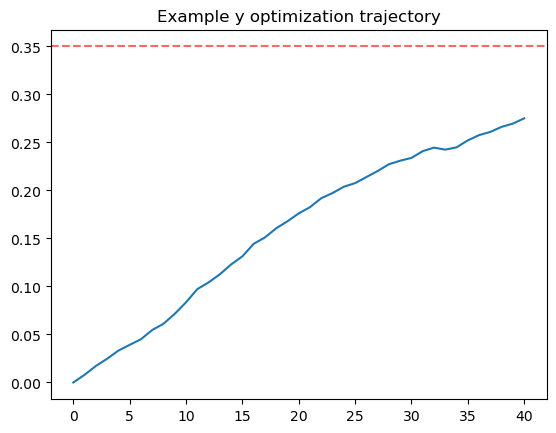

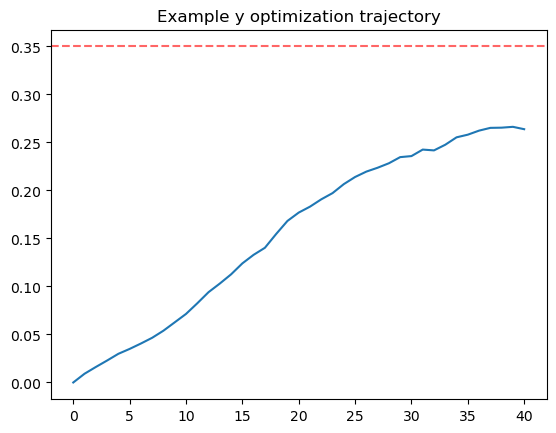

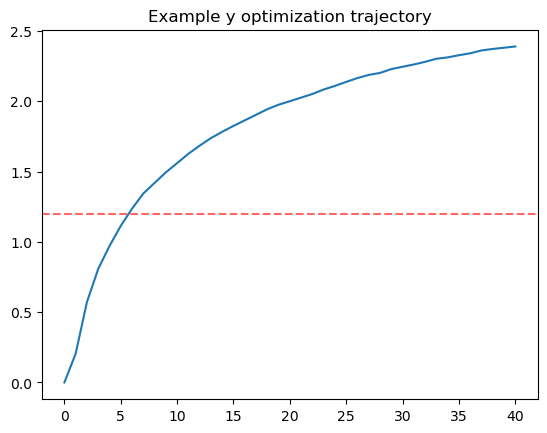

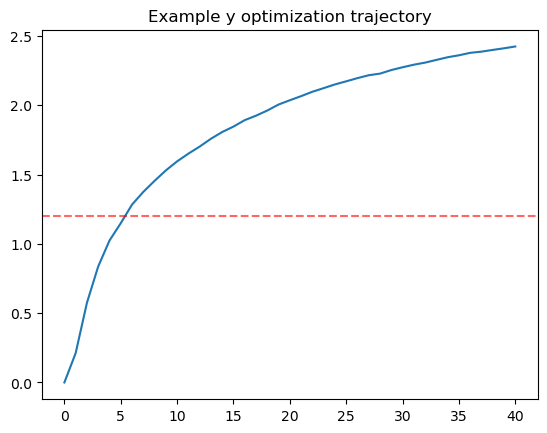

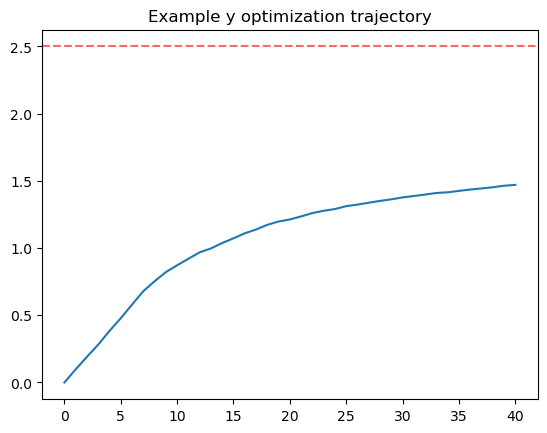

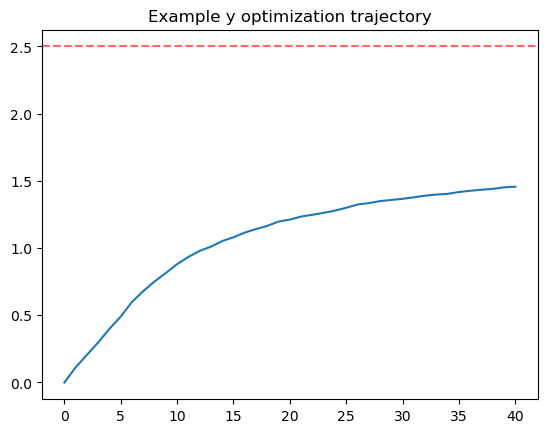

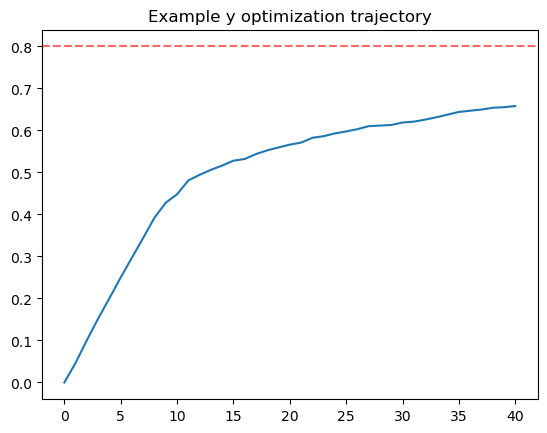

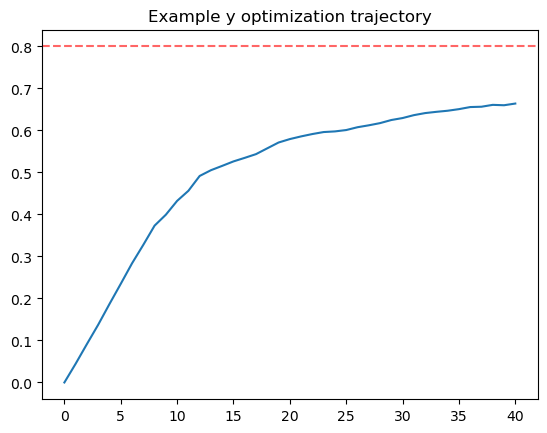

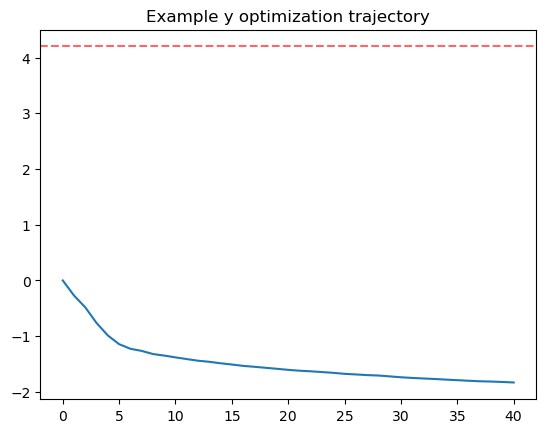

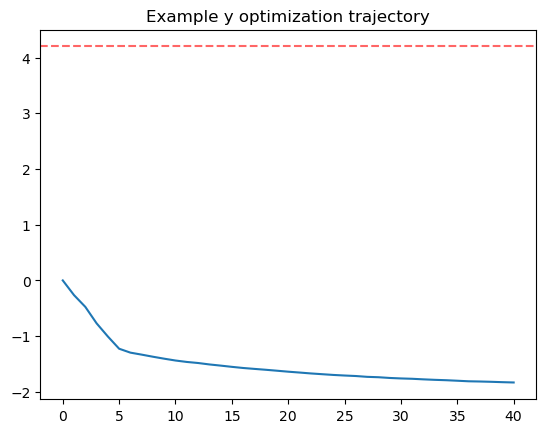

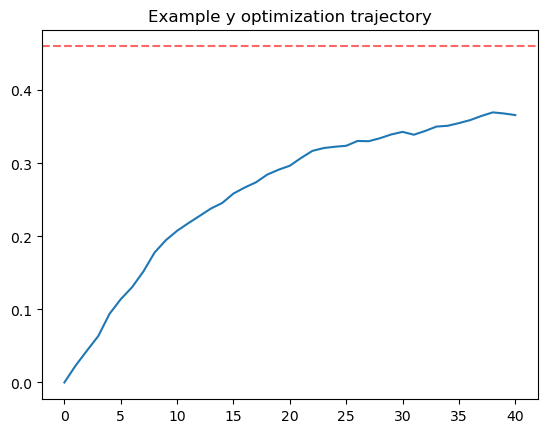

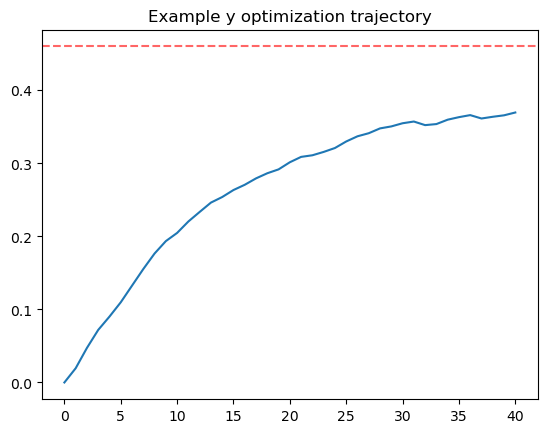

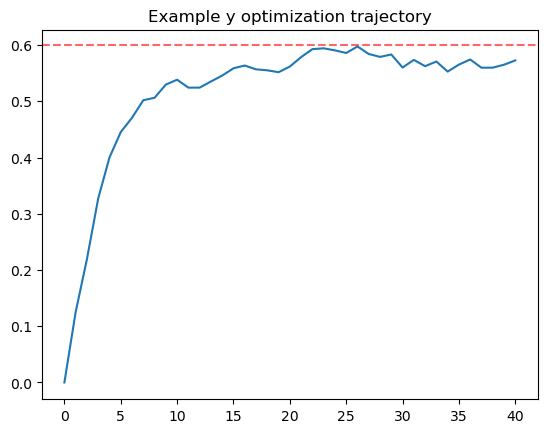

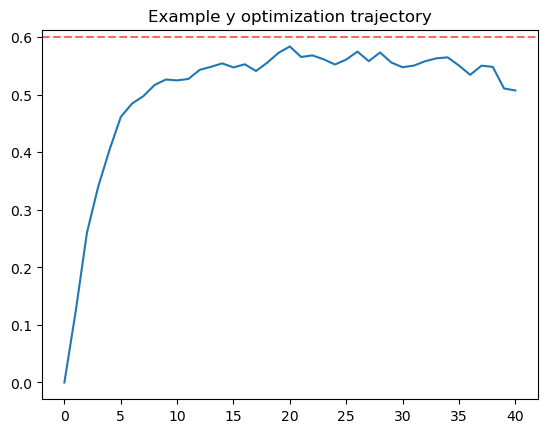

[TEST (path-inferred)]
  R²=0.752 | R²_adj=0.754 | MSE=0.816
  σ_pred=0.006 ± 0.001
  Within 1σ: 0.7% | Within 2σ: 1.5%


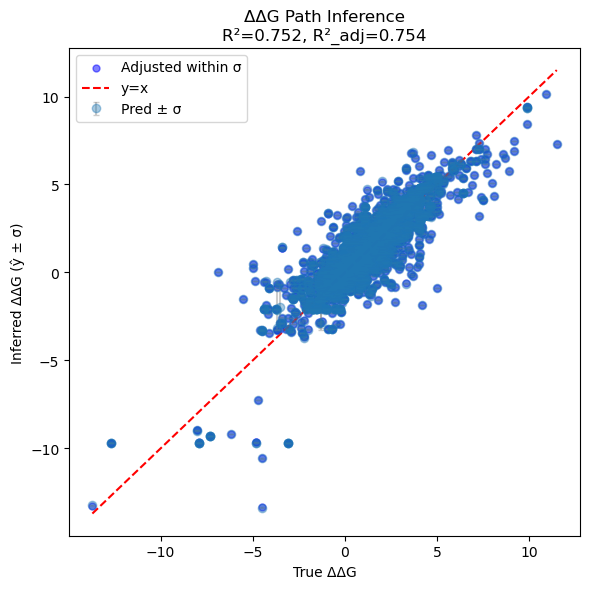

(0.7516214847564697,
 0.7540173530578613,
 0.81570095,
 0.0063771605,
 0.0005318039712627356,
 0.006831767719897523,
 0.014944491887275833)

In [5]:
import torch, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import sem

@torch.no_grad()
def evaluate_from_path(
    model, denoiser, loader,
    T, n_path_steps=None, n_paths=4,
    inner_steps=20, inner_lr=0.01,
    clamp=(-15.0, 20.0),
    device=None,
    n_traj_to_plot=3,
    clip_value=10.0,
    damping=0.3
):
    device = device or next(model.parameters()).device
    model.eval(); denoiser.eval()

    # --- diffusion schedule ---
    betas = torch.linspace(1e-4, 0.02, T).to(device)
    r_t = torch.ones_like(betas)
    n_steps = n_path_steps or T

    # --- path objective per sample ---
    def trajectory_path_objective_per_sample(z0, y):
        B, D = z0.shape
        dt = 1.0 / n_steps
        total_p = torch.zeros(B, device=device, dtype=z0.dtype)
        for _ in range(n_paths):
            zt = z0.clone()
            acc = torch.zeros_like(total_p)
            for k in range(n_steps):
                t_norm = torch.full((B, 1), k / n_steps, device=device, dtype=z0.dtype)
                beta_t = betas[min(int(k / n_steps * (T - 1)), T - 1)]
                drift_forward = -0.5 * beta_t * zt
                noise = torch.randn_like(zt)
                dz = drift_forward * dt + torch.sqrt(beta_t * dt) * noise
                zt = zt + dz

                s = denoiser(zt, t_norm * T, y)
                grad_U = zt
                drift_term = 0.5 * r_t[k % len(r_t)] * (
                    -s.pow(2).sum(dim=1) + (s * grad_U).sum(dim=1)
                )
                work_term = (s * dz).sum(dim=1)
                acc += drift_term + work_term
            total_p += acc
        return (total_p / n_paths).mean()

    # --- inner inference loop (gradient-based inference of y) ---
    def infer_y_unrolled(z0, record_trajectory=False):
        B = z0.size(0)
        y = torch.zeros(B, 1, device=device, requires_grad=True)
        trajectory = [y.detach().cpu().numpy().flatten()]
        for _ in range(inner_steps):
            with torch.enable_grad():
                Jb = trajectory_path_objective_per_sample(z0, y)
                grad_y = torch.autograd.grad(Jb, y, retain_graph=False, create_graph=False)[0]
            grad_y = torch.nan_to_num(grad_y, nan=0.0, posinf=0.0, neginf=0.0)

            # Damped, clamped gradient ascent
            new_y = (y + inner_lr * grad_y).clamp(*clamp)
            y = (1 - damping) * y + damping * new_y

            y = y.detach()
            y.requires_grad_(True)

            if record_trajectory:
                trajectory.append(y.detach().cpu().numpy().flatten())
        if record_trajectory:
            return y, np.stack(trajectory, axis=0)
        return y

    # --- evaluation loop ---
    y_true, y_pred_all = [], []

    for i, (seq, covars, ddg) in enumerate(loader):
        seq, covars, ddg = seq.to(device), covars.to(device), ddg.to(device)
        _, _, z = model(seq, covars)

        preds = []
        for _ in range(n_paths):
            pred, traj = infer_y_unrolled(z, record_trajectory=True)
            # visualize trajectory of first item
            if i > -1:
                plt.plot(traj[:,0])
                plt.axhline(ddg[0].item(), color='r', linestyle='--', alpha=0.6)
                plt.title("Example y optimization trajectory")
                plt.show()
            preds.append(pred.squeeze(1).cpu().numpy())
        preds = np.stack(preds, axis=0)
        y_pred_mean = preds.mean(axis=0)
        y_pred_std  = preds.std(axis=0)

        y_true.extend(ddg.cpu().numpy())
        y_pred_all.append(np.stack([y_pred_mean, y_pred_std], axis=1))

    # --- concatenate predictions ---
    y_true = np.array(y_true)
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_pred_mean, y_pred_std = y_pred_all[:, 0], y_pred_all[:, 1]

    # --- core metrics ---
    r2 = r2_score(y_true, y_pred_mean)
    mse = mean_squared_error(y_true, y_pred_mean)
    mean_err = np.mean(y_pred_std)
    sem_err  = sem(y_pred_std)

    # --- adjusted predictions (closest point within error bars) ---
    y_pred_adj = np.where(
        y_true < y_pred_mean - y_pred_std, y_pred_mean - y_pred_std,
        np.where(y_true > y_pred_mean + y_pred_std, y_pred_mean + y_pred_std, y_true)
    )
    r2_adj = r2_score(y_true, y_pred_adj)

    # --- calibration metrics ---
    within_1sigma = np.mean(np.abs(y_true - y_pred_mean) <= y_pred_std)
    within_2sigma = np.mean(np.abs(y_true - y_pred_mean) <= 2 * y_pred_std)

    print(f"[TEST (path-inferred)]")
    print(f"  R²={r2:.3f} | R²_adj={r2_adj:.3f} | MSE={mse:.3f}")
    print(f"  σ_pred={mean_err:.3f} ± {sem_err:.3f}")
    print(f"  Within 1σ: {within_1sigma*100:.1f}% | Within 2σ: {within_2sigma*100:.1f}%")

    # --- scatter plot with adjusted predictions ---
    plt.figure(figsize=(6,6))
    plt.errorbar(y_true, y_pred_mean, yerr=y_pred_std, fmt='o', alpha=0.4,
                 ecolor='gray', capsize=2, label="Pred ± σ")
    plt.scatter(y_true, y_pred_adj, c='blue', s=25, alpha=0.5, label="Adjusted within σ")
    lims = [min(y_true.min(), y_pred_mean.min()), max(y_true.max(), y_pred_mean.max())]
    plt.plot(lims, lims, 'r--', label='y=x')
    plt.xlabel("True ΔΔG")
    plt.ylabel("Inferred ΔΔG (ŷ ± σ)")
    plt.title(f"ΔΔG Path Inference\nR²={r2:.3f}, R²_adj={r2_adj:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return r2, r2_adj, mse, mean_err, sem_err, within_1sigma, within_2sigma


# Example call
evaluate_from_path(
    vae, denoiser, loaders["test"],
    T=T, n_path_steps=T, n_paths=2,
    inner_steps=40, inner_lr=0.05,
    clamp=(-15.0, 20.0), device=device,
    n_traj_to_plot=10,
    clip_value=5.0,
    damping=1.
)


[info] predicted ΔΔG shape: torch.Size([20])
[info] decoder weight shape = (462, 7), latent_dim=3, covar_dim=4
[info] projected likelihood shape = (462,)


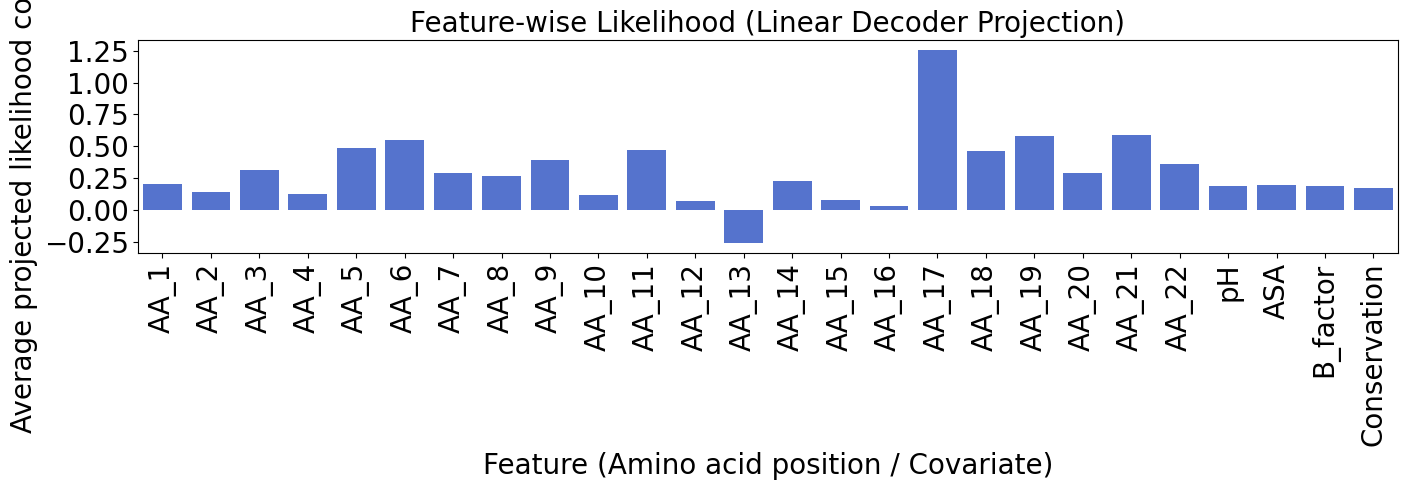

[saved] feature_likelihoods.svg (20 pt font, high-res SVG)


In [10]:
# =========================================================
# Interpretability via Linear Decoder Projection (SVG Export, 20pt Font)
# =========================================================
import torch, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Settings ---
n_samples = 20
T_eval = T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae.eval(); denoiser.eval()

# =========================================================
# Sample subset from test set
# =========================================================
subset_idx = np.random.choice(len(loaders["test"].dataset), n_samples, replace=False)
subset = [loaders["test"].dataset[i] for i in subset_idx]
seqs = torch.stack([s for (s, _, _) in subset]).to(device)
covars = torch.stack([c for (_, c, _) in subset]).to(device)
ddg_true = torch.stack([d for (_, _, d) in subset]).to(device)

# =========================================================
# Forward through model to get z and ΔΔG predictions
# =========================================================
with torch.no_grad():
    seq_logits, ddg_pred, z = vae(seqs, covars)
    ddg_pred = ddg_pred.squeeze()

print(f"[info] predicted ΔΔG shape: {ddg_pred.shape}")

# =========================================================
# Compute latent-space pathwise likelihood
# =========================================================
def compute_pathwise_likelihood(z0, y, denoiser, betas, r_t, T):
    """Compute thermodynamic likelihood integral per latent dimension."""
    B, D = z0.shape
    dt = 1.0 / T
    totals = torch.zeros(B, D, device=z0.device)
    zt = z0.clone()
    for k in range(T):
        t_norm = torch.full((B, 1), k / T, device=z0.device)
        beta_t = betas[k]
        drift_forward = -0.5 * beta_t * zt
        noise = torch.randn_like(zt)
        dz = drift_forward * dt + torch.sqrt(beta_t * dt) * noise
        s = denoiser(zt, t_norm * T, y)
        l_dim = 0.5 * r_t[k] * (-s**2 + s * zt) * dt + (s * dz)
        totals += l_dim
        zt = zt + dz
    return totals  # (B, latent_dim)

# --- Run likelihood computation ---
betas = torch.linspace(1e-4, 0.02, T_eval).to(device)
r_t = torch.ones_like(betas)
l_latent = compute_pathwise_likelihood(z, ddg_pred.unsqueeze(1), denoiser, betas, r_t, T_eval)
l_latent = l_latent.detach().cpu().numpy()

# =========================================================
# Project latent likelihoods → amino acid feature space
# =========================================================
W_dec = vae.decoder_linear.weight.detach().cpu().numpy()
b_dec = vae.decoder_linear.bias.detach().cpu().numpy()
output_dim, full_in_dim = W_dec.shape
latent_dim = l_latent.shape[1]
covar_dim = full_in_dim - latent_dim
print(f"[info] decoder weight shape = {W_dec.shape}, latent_dim={latent_dim}, covar_dim={covar_dim}")

# --- Pad latent likelihoods with zeros for covariate inputs ---
B = l_latent.shape[0]
l_full = np.concatenate([l_latent, np.zeros((B, covar_dim))], axis=1)

# --- Project into decoder output space ---
l_proj = l_full @ W_dec.T
l_proj_mean = l_proj.mean(axis=0)
print(f"[info] projected likelihood shape = {l_proj_mean.shape}")

# =========================================================
# Aggregate contributions by amino acid position
# =========================================================
L = vae.max_len
V = vae.vocab_size
AA_contribs = np.zeros(L)
for i in range(L):
    start, end = i * V, (i + 1) * V
    AA_contribs[i] = np.mean(l_proj_mean[start:end])

# =========================================================
# Add covariate contributions
# =========================================================
reg_weights = vae.reg_head.input_proj[0].weight.detach().cpu().numpy()
covar_contribs = np.mean(np.abs(reg_weights[:, -covar_dim:]), axis=0)

AA_labels = [f"AA_{i+1}" for i in range(L)]
cov_labels = ["pH", "ASA", "B_factor", "Conservation"]
all_labels = AA_labels + cov_labels
all_contribs = np.concatenate([AA_contribs, covar_contribs])

# =========================================================
# Plot feature-wise likelihood decomposition (SVG, 20pt)
# =========================================================
plt.figure(figsize=(14, 5))
sns.barplot(x=all_labels, y=all_contribs, color="royalblue")

plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Feature (Amino acid position / Covariate)", fontsize=20)
plt.ylabel("Average projected likelihood contribution", fontsize=20)
plt.title("Feature-wise Likelihood (Linear Decoder Projection)", fontsize=20)
plt.tight_layout()

plt.savefig("feature_likelihoods.svg", format="svg", dpi=300)
plt.show()
print("[saved] feature_likelihoods.svg (20 pt font, high-res SVG)")


[info] predicted ΔΔG shape: torch.Size([2000])
[info] decoder weight shape = (462, 7), latent_dim=3, covar_dim=4
[info] projected likelihood shape = (462,)


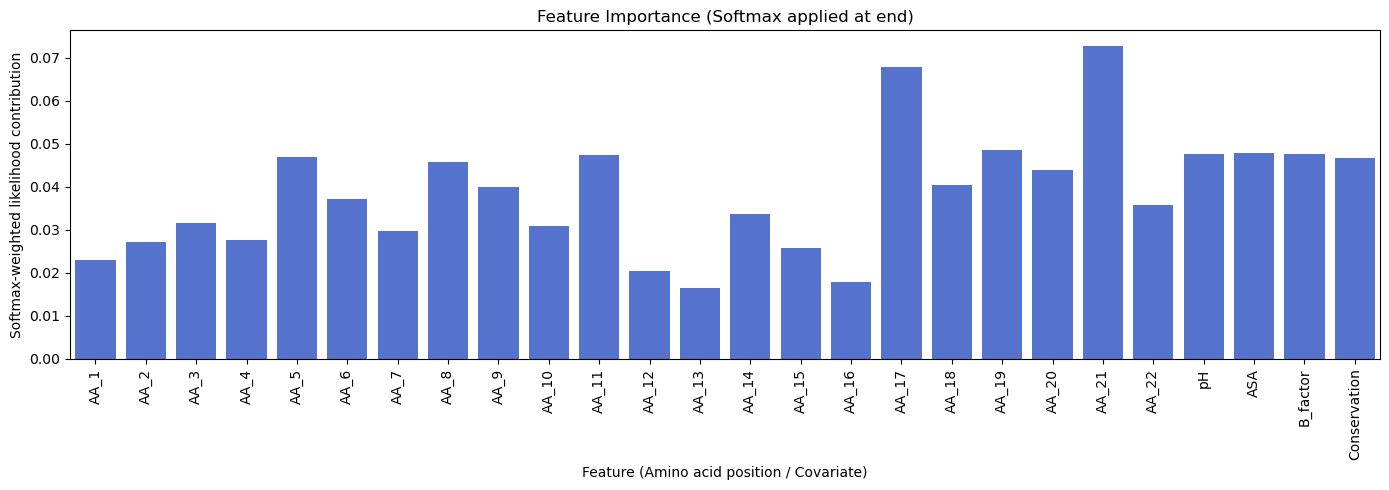

In [60]:
# =========================================================
# Interpretability via Linear Decoder Projection (Softmax at End)
# =========================================================
import torch, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Settings ---
n_samples = 2000        # number of random test points
T_eval = T           # diffusion time used in training (e.g., 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae.eval(); denoiser.eval()

# =========================================================
# Sample subset from test set
# =========================================================
subset_idx = np.random.choice(len(loaders["test"].dataset), n_samples, replace=False)
subset = [loaders["test"].dataset[i] for i in subset_idx]
seqs = torch.stack([s for (s, _, _) in subset]).to(device)
covars = torch.stack([c for (_, c, _) in subset]).to(device)
ddg_true = torch.stack([d for (_, _, d) in subset]).to(device)

# =========================================================
# Forward through model to get z and ΔΔG predictions
# =========================================================
with torch.no_grad():
    seq_logits, ddg_pred, z = vae(seqs, covars)
    ddg_pred = ddg_pred.squeeze()

print(f"[info] predicted ΔΔG shape: {ddg_pred.shape}")

# =========================================================
# Compute latent-space pathwise likelihood
# =========================================================
def compute_pathwise_likelihood(z0, y, denoiser, betas, r_t, T):
    """Compute thermodynamic likelihood integral per latent dimension"""
    B, D = z0.shape
    dt = 1.0 / T
    totals = torch.zeros(B, D, device=z0.device)
    zt = z0.clone()
    for k in range(T):
        t_norm = torch.full((B, 1), k / T, device=z0.device)
        beta_t = betas[k]
        drift_forward = -0.5 * beta_t * zt
        noise = torch.randn_like(zt)
        dz = drift_forward * dt + torch.sqrt(beta_t * dt) * noise
        s = denoiser(zt, t_norm * T, y)
        l_dim = 0.5 * r_t[k] * (-s**2 + s * zt) * dt + (s * dz)
        totals += l_dim
        zt = zt + dz
    return totals  # (B, latent_dim)

# --- Run likelihood computation ---
betas = torch.linspace(1e-4, 0.02, T_eval).to(device)
r_t = torch.ones_like(betas)
l_latent = compute_pathwise_likelihood(z, ddg_pred.unsqueeze(1), denoiser, betas, r_t, T_eval)
l_latent = l_latent.detach().cpu().numpy()

# =========================================================
# Project latent likelihoods → amino acid feature space
# =========================================================
W_dec = vae.decoder_linear.weight.detach().cpu().numpy()  # (output_dim, latent+covar)
b_dec = vae.decoder_linear.bias.detach().cpu().numpy()
output_dim, full_in_dim = W_dec.shape
latent_dim = l_latent.shape[1]
covar_dim = full_in_dim - latent_dim
print(f"[info] decoder weight shape = {W_dec.shape}, latent_dim={latent_dim}, covar_dim={covar_dim}")

# --- Pad latent likelihoods with zeros for covariate inputs ---
B = l_latent.shape[0]
l_full = np.concatenate([l_latent, np.zeros((B, covar_dim))], axis=1)

# --- Project into decoder output space ---
l_proj = l_full @ W_dec.T    # shape [B, output_dim]
l_proj_mean = l_proj.mean(axis=0)
print(f"[info] projected likelihood shape = {l_proj_mean.shape}")

# =========================================================
# Aggregate contributions by amino acid position
# =========================================================
L = vae.max_len
V = vae.vocab_size
AA_contribs = np.zeros(L)
for i in range(L):
    start, end = i * V, (i + 1) * V
    AA_contribs[i] = np.mean(l_proj_mean[start:end])

# =========================================================
# Add covariate contributions from regression head
# =========================================================
reg_weights = vae.reg_head.input_proj[0].weight.detach().cpu().numpy()  # [hidden_dim, latent+covar_dim]
covar_contribs = np.mean(np.abs(reg_weights[:, -covar_dim:]), axis=0)

AA_labels = [f"AA_{i+1}" for i in range(L)]
cov_labels = ["pH", "ASA", "B_factor", "Conservation"]
all_labels = AA_labels + cov_labels
all_contribs = np.concatenate([AA_contribs, covar_contribs])

# =========================================================
# Apply Softmax *after* aggregation (amplify strong positive features)
# =========================================================
tau = 1.0  # temperature for softmax (lower -> more peaked)
exp_vals = np.exp(all_contribs / tau)
softmax_contribs = exp_vals / np.sum(exp_vals)

# =========================================================
# Plot feature-wise likelihood decomposition
# =========================================================
plt.figure(figsize=(14, 5))
sns.barplot(x=all_labels, y=softmax_contribs, color="royalblue")
plt.xticks(rotation=90)
plt.xlabel("Feature (Amino acid position / Covariate)")
plt.ylabel("Softmax-weighted likelihood contribution")
plt.title("Feature Importance (Softmax applied at end)")
plt.tight_layout()
plt.show()


[TEST] R²=0.780 | MSE=0.722


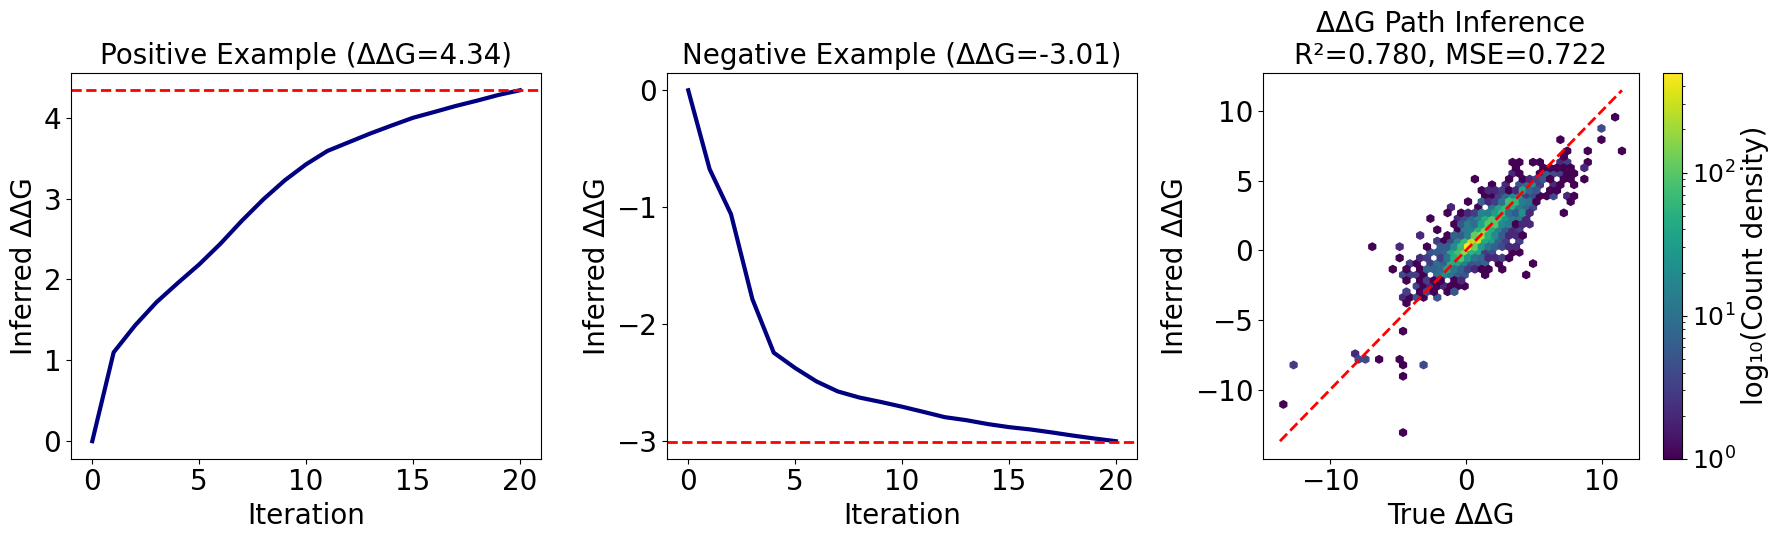

[saved] 3-panel plot saved to ddg_threepanel.svg


(0.7801770783012576, 0.7219213784294978)

In [86]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

@torch.no_grad()
def evaluate_from_path(
    model, denoiser, loader,
    T, n_path_steps=None, n_paths=4,
    inner_steps=20, inner_lr=0.01,
    clamp=(-15.0, 20.0),
    device=None,
    clip_value=10.0,
    damping=0.3,
    save_path="ddg_threepanel.svg"
):
    """Evaluate ΔΔG inference with 2 representative trajectories and a density plot."""
    device = device or next(model.parameters()).device
    model.eval(); denoiser.eval()

    # --- diffusion schedule ---
    betas = torch.linspace(1e-4, 0.02, T).to(device)
    r_t = torch.ones_like(betas)
    n_steps = n_path_steps or T

    # --- path objective ---
    def trajectory_path_objective_per_sample(z0, y):
        B, D = z0.shape
        dt = 1.0 / n_steps
        total_p = torch.zeros(B, device=device, dtype=z0.dtype)
        for _ in range(n_paths):
            zt = z0.clone()
            acc = torch.zeros_like(total_p)
            for k in range(n_steps):
                t_norm = torch.full((B, 1), k / n_steps, device=device, dtype=z0.dtype)
                beta_t = betas[min(int(k / n_steps * (T - 1)), T - 1)]
                drift_forward = -0.5 * beta_t * zt
                noise = torch.randn_like(zt)
                dz = drift_forward * dt + torch.sqrt(beta_t * dt) * noise
                zt = zt + dz
                s = denoiser(zt, t_norm * T, y)
                grad_U = zt
                drift_term = 0.5 * r_t[k % len(r_t)] * (-s.pow(2).sum(dim=1) + (s * grad_U).sum(dim=1))
                work_term = (s * dz).sum(dim=1)
                acc += drift_term + work_term
            total_p += acc
        return (total_p / n_paths).mean()

    # --- inner inference ---
    def infer_y_unrolled(z0, record_trajectory=False):
        B = z0.size(0)
        y = torch.zeros(B, 1, device=device, requires_grad=True)
        trajectory = [y.detach().cpu().numpy()]
        for _ in range(inner_steps):
            with torch.enable_grad():
                Jb = trajectory_path_objective_per_sample(z0, y)
                grad_y = torch.autograd.grad(Jb, y, retain_graph=False, create_graph=False)[0]
            grad_y = torch.nan_to_num(grad_y, nan=0.0, posinf=0.0, neginf=0.0)
            new_y = (y + inner_lr * grad_y).clamp(*clamp)
            y = (1 - damping) * y + damping * new_y
            y = y.detach(); y.requires_grad_(True)
            if record_trajectory:
                trajectory.append(y.detach().cpu().numpy())
        if record_trajectory:
            return y, np.stack(trajectory, axis=0)
        return y

    # --- evaluation loop ---
    y_true, y_pred_all = [], []
    all_trajs, all_ddg = [], []

    for seq, covars, ddg in loader:
        seq, covars, ddg = seq.to(device), covars.to(device), ddg.to(device)
        _, _, z = model(seq, covars)
        pred, traj = infer_y_unrolled(z, record_trajectory=True)
        y_pred = pred.squeeze(1).cpu().numpy()
        traj = traj.squeeze(-1)
        for b in range(len(y_pred)):
            y_true.append(ddg[b].item())
            y_pred_all.append(y_pred[b])
            all_trajs.append(traj[:, b])
            all_ddg.append(ddg[b].item())

    y_true = np.array(y_true)
    y_pred_all = np.array(y_pred_all)

    # --- metrics ---
    r2 = r2_score(y_true, y_pred_all)
    mse = mean_squared_error(y_true, y_pred_all)
    print(f"[TEST] R²={r2:.3f} | MSE={mse:.3f}")

    # =========================================================
    # Select 2 representative examples (|ΔΔG| > 1)
    # =========================================================
    mask = np.abs(y_true) > 1
    idx_filtered = np.where(mask)[0]
    errors = np.abs(y_true[idx_filtered] - y_pred_all[idx_filtered])
    sorted_idx = idx_filtered[np.argsort(errors)]

    pos_idx = next((i for i in sorted_idx if y_true[i] > 1), None)
    neg_idx = next((i for i in sorted_idx if y_true[i] < -1), None)

    # =========================================================
    # Plot 3 panels (pos, neg, density)
    # =========================================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

    def style_axis(ax):
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.title.set_size(20)

    # --- Positive example ---
    if pos_idx is not None:
        ax = axes[0]
        ax.plot(all_trajs[pos_idx], lw=3, color='navy')
        ax.axhline(all_ddg[pos_idx], color='r', ls='--', lw=2)
        ax.set_title(f"Positive Example (ΔΔG={all_ddg[pos_idx]:.2f})")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Inferred ΔΔG")
        style_axis(ax)

    # --- Negative example ---
    if neg_idx is not None:
        ax = axes[1]
        ax.plot(all_trajs[neg_idx], lw=3, color='navy')
        ax.axhline(all_ddg[neg_idx], color='r', ls='--', lw=2)
        ax.set_title(f"Negative Example (ΔΔG={all_ddg[neg_idx]:.2f})")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Inferred ΔΔG")
        style_axis(ax)

    # --- Density plot ---
    ax = axes[2]
    hb = ax.hexbin(
        y_true, y_pred_all,
        gridsize=50, cmap="viridis", bins='log', mincnt=1
    )
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("log₁₀(Count density)", fontsize=20)
    cb.ax.tick_params(labelsize=18)
    lims = [min(y_true.min(), y_pred_all.min()), max(y_true.max(), y_pred_all.max())]
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlabel("True ΔΔG")
    ax.set_ylabel("Inferred ΔΔG")
    ax.set_title(f"ΔΔG Path Inference\nR²={r2:.3f}, MSE={mse:.3f}")
    style_axis(ax)

    plt.tight_layout()
    plt.savefig(save_path, format="svg", dpi=300)
    plt.show()
    print(f"[saved] 3-panel plot saved to {save_path}")

    return r2, mse


# Example evaluation
evaluate_from_path(
    vae, denoiser, loaders["test"],
    T=T, n_path_steps=T, n_paths=2,
    inner_steps=20, inner_lr=0.06,
    clamp=(-15.0, 20.0), device=device,
    clip_value=5.0, damping=1.0,
    save_path="ddg_threepanel.svg"
)
